# Imports

In [1]:
from importlib import reload
import json
import logging
import time
from argparse import ArgumentParser
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import datasets
from model import CNN, MyDartsTrainer

import utils

c:\Users\pkbab\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Hyperparameters

In [21]:
layers = 1
batch_size = 64
log_frequency = 40
channels = 16
unrolled = False
visualization = False

# Getting dataset

In [22]:
dataset = "cifar100"

dataset_train, dataset_valid = datasets.get_dataset(dataset)        

Files already downloaded and verified
Files already downloaded and verified


# Architecture search for a range of $\lambda$

In [23]:
logs = {}

In [24]:
import numpy as np
def warmup_weight(epoch, epochs):
    minim, maxim = 0, 0.2
    return minim + (epoch / epochs) * (maxim - minim)

def warmup_t(epoch, epochs):
    minim, maxim = 0.01, 1
    return maxim - (epoch / epochs) * (maxim - minim)

weight = yes, temoreture = no lambd = 1
Epoch [1/50] Step [1/391]  acc1 0.015625 (0.015625)  loss 4.608945 (4.608945)
Epoch [1/50] Step [41/391]  acc1 0.062500 (0.020579)  loss 4.454943 (4.569154)
Epoch [1/50] Step [81/391]  acc1 0.000000 (0.028935)  loss 4.342885 (4.476638)
Epoch [1/50] Step [121/391]  acc1 0.031250 (0.038611)  loss 4.317755 (4.404275)
Epoch [1/50] Step [161/391]  acc1 0.046875 (0.043672)  loss 4.310743 (4.357192)
Epoch [1/50] Step [201/391]  acc1 0.093750 (0.049207)  loss 4.158164 (4.309871)
Epoch [1/50] Step [241/391]  acc1 0.062500 (0.053812)  loss 4.048506 (4.268869)
Epoch [1/50] Step [281/391]  acc1 0.093750 (0.058163)  loss 4.001253 (4.237357)
Epoch [1/50] Step [321/391]  acc1 0.046875 (0.060991)  loss 3.996448 (4.211487)
Epoch [1/50] Step [361/391]  acc1 0.109375 (0.064707)  loss 4.042011 (4.187936)
Epoch [2/50] Step [1/391]  acc1 0.046875 (0.046875)  loss 3.961556 (3.961556)
Epoch [2/50] Step [41/391]  acc1 0.046875 (0.094893)  loss 4.126349 (3.959106)
Epoch [

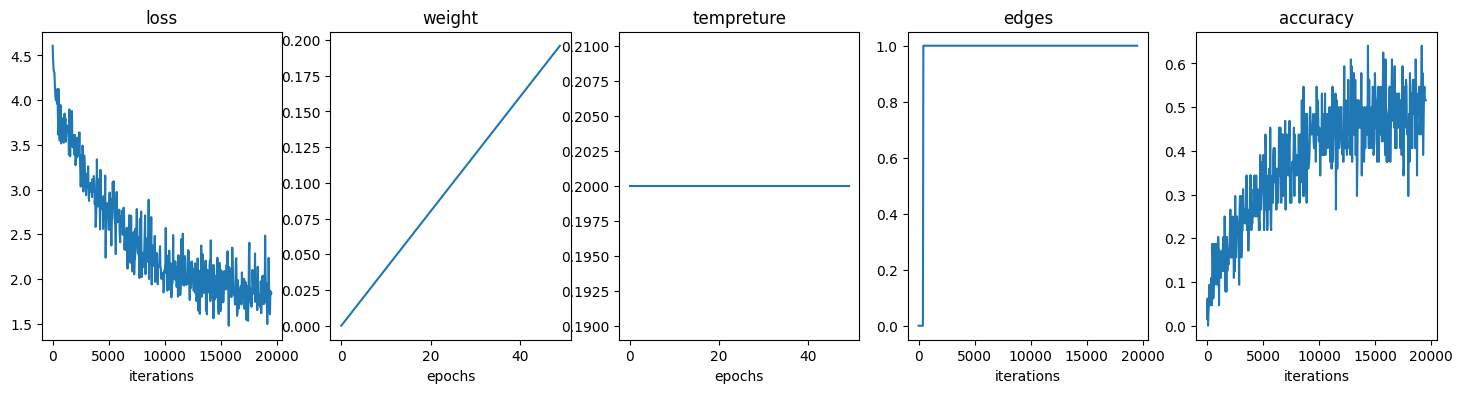

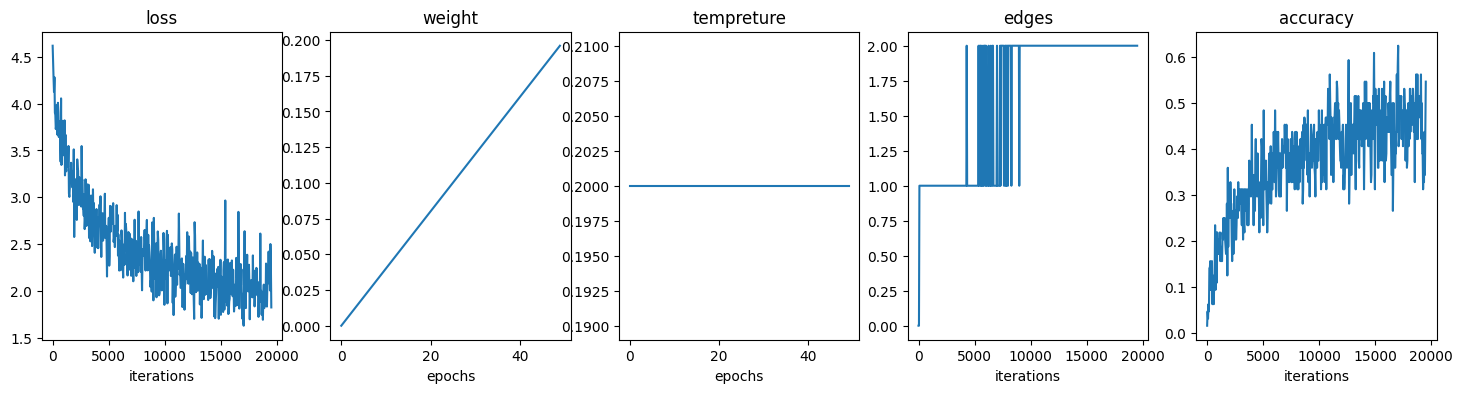

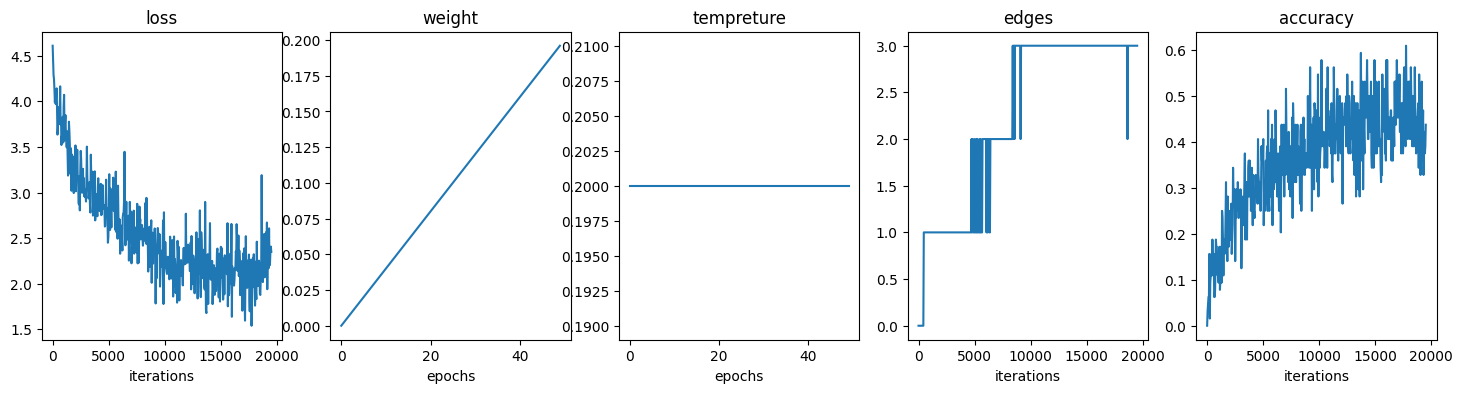

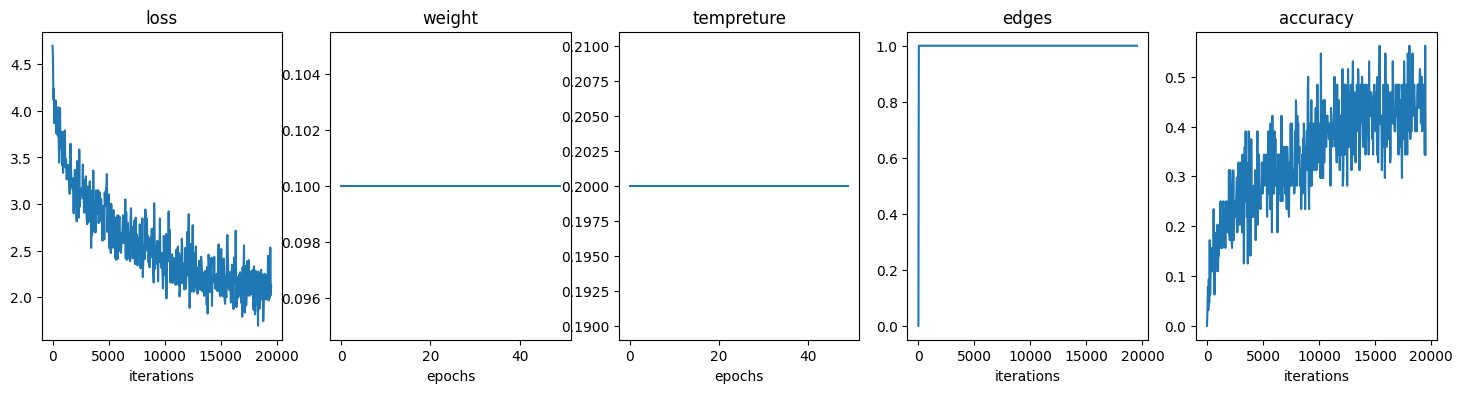

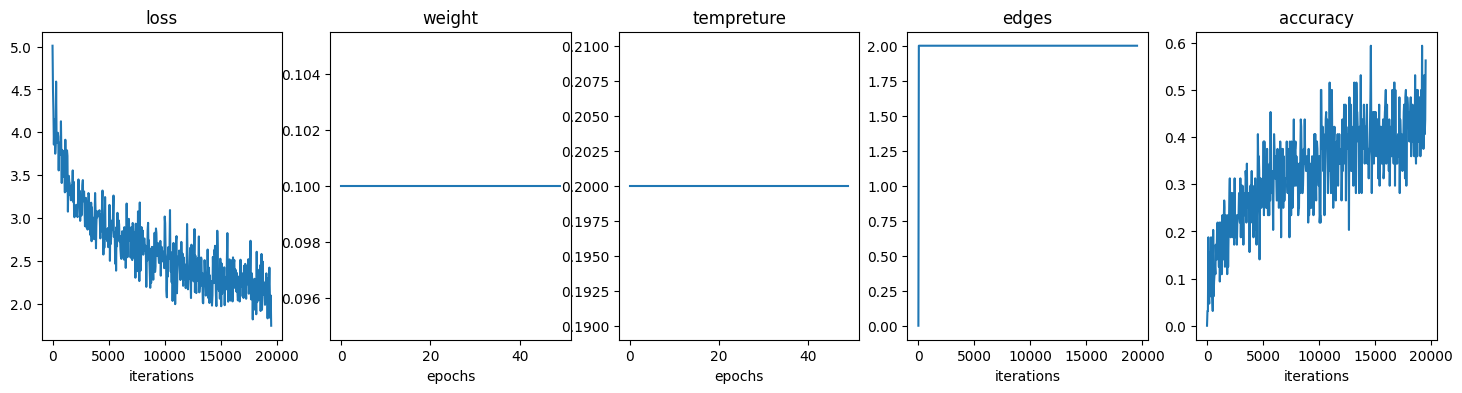

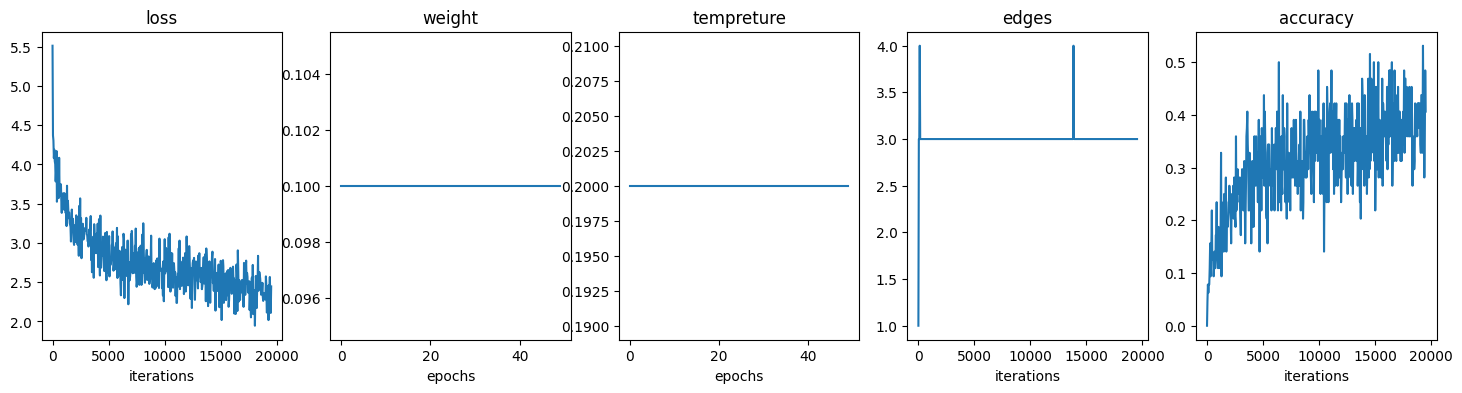

In [25]:
epochs = 50
lambd = 1
n_chosen = 1
weight = 0.1
wt = None
for ww in [warmup_weight, None]:
    for lambd in [1, 2, 3]:
        wr = utils.Writer()
        wr.new_name('loss')
        wr.new_name('weight')
        wr.new_name('tempreture')
        wr.new_name('edges')
        wr.new_name('accuracy')

        ww_label = "no" if ww is None else "yes"
        wt_label = "no" if wt is None else "yes"

        print(f"weight = {ww_label}, temoreture = {wt_label} lambd = {lambd}")
        if dataset == "fashionmnist":
            model = CNN(32, 1, channels, 10, layers, n_chosen=1)
        elif dataset == "cifar10":
            model = CNN(32, 3, channels, 10, layers, n_chosen=1)
        elif dataset == "cifar100":
            model = CNN(32, 3, channels, 100, layers, n_chosen=1)

        criterion = nn.CrossEntropyLoss() # mycriterion()
        optim = torch.optim.SGD(model.parameters(), 0.025, momentum=0.9, weight_decay=3.0E-4)
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, epochs, eta_min=0.001)
        trainer = MyDartsTrainer(
            model=model,
            loss=criterion, # =mycriterion,
            metrics=lambda output, target: utils.accuracy(output, target, topk=(1,)),
            optimizer=optim,
            num_epochs=epochs,
            dataset=dataset_train,
            batch_size=batch_size,
            log_frequency=log_frequency,
            unrolled=unrolled,
            weight=weight, # вес регуляризатора
            lambd=lambd, # количество общих ребер
            train_as_optimal=False,
            optimalPath='checkpoints/CIFAR100/optimal/arc.json',
            tau=1.0,
            learning_rate=2.5E-3,
            arc_learning_rate=3.0E-1,
            n_chosen=1,
            t_alpha=0.2,
            t_beta=0.2,
        )
        trainer.fit(writer=wr, warmup_t=wt, warmup_weight=ww)
        final_architecture = trainer.export()
        print('Final architecture:', final_architecture)
        if trainer.train_as_optimal:
            json.dump(trainer.export(), open(f'checkpoints/CIFAR100/optimal/arc1.json', 'w+'))
        else:
            json.dump(trainer.export(), open(f'checkpoints/CIFAR100/lambd={lambd}/ww={ww_label}wt={wt_label}/arc1.json', 'w+'))
        logs.update({ f'lambd={lambd}, weight={ww_label}, tempreture={wt_label}' : wr })
        wr.show()

In [46]:
arcs = [{'reduce_n2_p0': 'sepconv5x5', 'reduce_n2_p1': 'maxpool', 'reduce_n3_p0': 'dilconv3x3', 'reduce_n3_p1': 'avgpool', 'reduce_n3_p2': 'sepconv5x5', 'reduce_n4_p0': 'skipconnect', 'reduce_n4_p1': 'sepconv5x5', 'reduce_n4_p2': 'dilconv3x3', 'reduce_n4_p3': 'maxpool', 'reduce_n5_p0': 'sepconv3x3', 'reduce_n5_p1': 'sepconv5x5', 'reduce_n5_p2': 'sepconv5x5', 'reduce_n5_p3': 'dilconv5x5', 'reduce_n5_p4': 'maxpool', 'reduce_n2_switch': [0], 'reduce_n3_switch': [2], 'reduce_n4_switch': [3], 'reduce_n5_switch': [4]},
{'reduce_n2_p0': 'sepconv5x5', 'reduce_n2_p1': 'avgpool', 'reduce_n3_p0': 'maxpool', 'reduce_n3_p1': 'dilconv5x5', 'reduce_n3_p2': 'sepconv5x5', 'reduce_n4_p0': 'dilconv3x3', 'reduce_n4_p1': 'maxpool', 'reduce_n4_p2': 'avgpool', 'reduce_n4_p3': 'sepconv3x3', 'reduce_n5_p0': 'maxpool', 'reduce_n5_p1': 'avgpool', 'reduce_n5_p2': 'sepconv5x5', 'reduce_n5_p3': 'skipconnect', 'reduce_n5_p4': 'dilconv3x3', 'reduce_n2_switch': [0], 'reduce_n3_switch': [2], 'reduce_n4_switch': [3], 'reduce_n5_switch': [4]},
{'reduce_n2_p0': 'sepconv3x3', 'reduce_n2_p1': 'sepconv5x5', 'reduce_n3_p0': 'avgpool', 'reduce_n3_p1': 'maxpool', 'reduce_n3_p2': 'sepconv5x5', 'reduce_n4_p0': 'avgpool', 'reduce_n4_p1': 'dilconv3x3', 'reduce_n4_p2': 'avgpool', 'reduce_n4_p3': 'sepconv3x3', 'reduce_n5_p0': 'sepconv3x3', 'reduce_n5_p1': 'sepconv3x3', 'reduce_n5_p2': 'skipconnect', 'reduce_n5_p3': 'maxpool', 'reduce_n5_p4': 'maxpool', 'reduce_n2_switch': [1], 'reduce_n3_switch': [2], 'reduce_n4_switch': [3], 'reduce_n5_switch': [3]},
{'reduce_n2_p0': 'maxpool', 'reduce_n2_p1': 'dilconv5x5', 'reduce_n3_p0': 'sepconv3x3', 'reduce_n3_p1': 'skipconnect', 'reduce_n3_p2': 'sepconv5x5', 'reduce_n4_p0': 'avgpool', 'reduce_n4_p1': 'dilconv3x3', 'reduce_n4_p2': 'skipconnect', 'reduce_n4_p3': 'sepconv3x3', 'reduce_n5_p0': 'dilconv5x5', 'reduce_n5_p1': 'dilconv3x3', 'reduce_n5_p2': 'dilconv3x3', 'reduce_n5_p3': 'maxpool', 'reduce_n5_p4': 'sepconv5x5', 'reduce_n2_switch': [1], 'reduce_n3_switch': [2], 'reduce_n4_switch': [3], 'reduce_n5_switch': [3]},
{'reduce_n2_p0': 'sepconv5x5', 'reduce_n2_p1': 'sepconv5x5', 'reduce_n3_p0': 'sepconv5x5', 'reduce_n3_p1': 'sepconv5x5', 'reduce_n3_p2': 'maxpool', 'reduce_n4_p0': 'skipconnect', 'reduce_n4_p1': 'dilconv5x5', 'reduce_n4_p2': 'dilconv3x3', 'reduce_n4_p3': 'sepconv3x3', 'reduce_n5_p0': 'dilconv3x3', 'reduce_n5_p1': 'maxpool', 'reduce_n5_p2': 'dilconv5x5', 'reduce_n5_p3': 'skipconnect', 'reduce_n5_p4': 'maxpool', 'reduce_n2_switch': [1], 'reduce_n3_switch': [2], 'reduce_n4_switch': [3], 'reduce_n5_switch': [2]},
{'reduce_n2_p0': 'sepconv3x3', 'reduce_n2_p1': 'dilconv5x5', 'reduce_n3_p0': 'skipconnect', 'reduce_n3_p1': 'sepconv3x3', 'reduce_n3_p2': 'sepconv5x5', 'reduce_n4_p0': 'dilconv3x3', 'reduce_n4_p1': 'dilconv3x3', 'reduce_n4_p2': 'dilconv5x5', 'reduce_n4_p3': 'maxpool', 'reduce_n5_p0': 'sepconv5x5', 'reduce_n5_p1': 'sepconv5x5', 'reduce_n5_p2': 'dilconv5x5', 'reduce_n5_p3': 'avgpool', 'reduce_n5_p4': 'maxpool', 'reduce_n2_switch': [1], 'reduce_n3_switch': [2], 'reduce_n4_switch': [3], 'reduce_n5_switch': [4]},
{'reduce_n2_p0': 'skipconnect', 'reduce_n2_p1': 'dilconv5x5', 'reduce_n3_p0': 'sepconv5x5', 'reduce_n3_p1': 'sepconv3x3', 'reduce_n3_p2': 'avgpool', 'reduce_n4_p0': 'dilconv5x5', 'reduce_n4_p1': 'dilconv5x5', 'reduce_n4_p2': 'sepconv5x5', 'reduce_n4_p3': 'sepconv3x3', 'reduce_n5_p0': 'maxpool', 'reduce_n5_p1': 'sepconv5x5', 'reduce_n5_p2': 'sepconv3x3', 'reduce_n5_p3': 'maxpool', 'reduce_n5_p4': 'dilconv5x5', 'reduce_n2_switch': [1], 'reduce_n3_switch': [0], 'reduce_n4_switch': [3], 'reduce_n5_switch': [3]},
{'reduce_n2_p0': 'dilconv5x5', 'reduce_n2_p1': 'dilconv5x5', 'reduce_n3_p0': 'sepconv5x5', 'reduce_n3_p1': 'skipconnect', 'reduce_n3_p2': 'sepconv5x5', 'reduce_n4_p0': 'avgpool', 'reduce_n4_p1': 'sepconv5x5', 'reduce_n4_p2': 'dilconv3x3', 'reduce_n4_p3': 'sepconv3x3', 'reduce_n5_p0': 'skipconnect', 'reduce_n5_p1': 'sepconv5x5', 'reduce_n5_p2': 'sepconv5x5', 'reduce_n5_p3': 'maxpool', 'reduce_n5_p4': 'maxpool', 'reduce_n2_switch': [1], 'reduce_n3_switch': [2], 'reduce_n4_switch': [3], 'reduce_n5_switch': [3]},
{'reduce_n2_p0': 'maxpool', 'reduce_n2_p1': 'sepconv5x5', 'reduce_n3_p0': 'sepconv5x5', 'reduce_n3_p1': 'skipconnect', 'reduce_n3_p2': 'maxpool', 'reduce_n4_p0': 'dilconv5x5', 'reduce_n4_p1': 'sepconv5x5', 'reduce_n4_p2': 'maxpool', 'reduce_n4_p3': 'maxpool', 'reduce_n5_p0': 'sepconv3x3', 'reduce_n5_p1': 'dilconv3x3', 'reduce_n5_p2': 'sepconv5x5', 'reduce_n5_p3': 'maxpool', 'reduce_n5_p4': 'sepconv5x5', 'reduce_n2_switch': [1], 'reduce_n3_switch': [2], 'reduce_n4_switch': [3], 'reduce_n5_switch': [3]},
{'reduce_n2_p0': 'skipconnect', 'reduce_n2_p1': 'dilconv5x5', 'reduce_n3_p0': 'maxpool', 'reduce_n3_p1': 'dilconv3x3', 'reduce_n3_p2': 'sepconv5x5', 'reduce_n4_p0': 'sepconv5x5', 'reduce_n4_p1': 'maxpool', 'reduce_n4_p2': 'sepconv5x5', 'reduce_n4_p3': 'sepconv3x3', 'reduce_n5_p0': 'maxpool', 'reduce_n5_p1': 'skipconnect', 'reduce_n5_p2': 'sepconv5x5', 'reduce_n5_p3': 'dilconv5x5', 'reduce_n5_p4': 'maxpool', 'reduce_n2_switch': [1], 'reduce_n3_switch': [2], 'reduce_n4_switch': [3], 'reduce_n5_switch': [4]},
{'reduce_n2_p0': 'skipconnect', 'reduce_n2_p1': 'dilconv5x5', 'reduce_n3_p0': 'sepconv3x3', 'reduce_n3_p1': 'dilconv3x3', 'reduce_n3_p2': 'sepconv5x5', 'reduce_n4_p0': 'sepconv3x3', 'reduce_n4_p1': 'maxpool', 'reduce_n4_p2': 'maxpool', 'reduce_n4_p3': 'sepconv3x3', 'reduce_n5_p0': 'dilconv3x3', 'reduce_n5_p1': 'sepconv3x3', 'reduce_n5_p2': 'skipconnect', 'reduce_n5_p3': 'sepconv3x3', 'reduce_n5_p4': 'sepconv3x3', 'reduce_n2_switch': [1], 'reduce_n3_switch': [2], 'reduce_n4_switch': [3], 'reduce_n5_switch': [3]},
{'reduce_n2_p0': 'dilconv5x5', 'reduce_n2_p1': 'dilconv5x5', 'reduce_n3_p0': 'dilconv3x3', 'reduce_n3_p1': 'sepconv3x3', 'reduce_n3_p2': 'sepconv5x5', 'reduce_n4_p0': 'maxpool', 'reduce_n4_p1': 'dilconv5x5', 'reduce_n4_p2': 'maxpool', 'reduce_n4_p3': 'sepconv3x3', 'reduce_n5_p0': 'maxpool', 'reduce_n5_p1': 'sepconv5x5', 'reduce_n5_p2': 'maxpool', 'reduce_n5_p3': 'maxpool', 'reduce_n5_p4': 'dilconv5x5', 'reduce_n2_switch': [1], 'reduce_n3_switch': [2], 'reduce_n4_switch': [3], 'reduce_n5_switch': [3]},
{'reduce_n2_p0': 'sepconv3x3', 'reduce_n2_p1': 'sepconv5x5', 'reduce_n3_p0': 'sepconv5x5', 'reduce_n3_p1': 'sepconv5x5', 'reduce_n3_p2': 'maxpool', 'reduce_n4_p0': 'dilconv5x5', 'reduce_n4_p1': 'skipconnect', 'reduce_n4_p2': 'sepconv5x5', 'reduce_n4_p3': 'maxpool', 'reduce_n5_p0': 'sepconv3x3', 'reduce_n5_p1': 'sepconv5x5', 'reduce_n5_p2': 'dilconv3x3', 'reduce_n5_p3': 'maxpool', 'reduce_n5_p4': 'maxpool', 'reduce_n2_switch': [1], 'reduce_n3_switch': [2], 'reduce_n4_switch': [3], 'reduce_n5_switch': [3]},
{'reduce_n2_p0': 'sepconv5x5', 'reduce_n2_p1': 'skipconnect', 'reduce_n3_p0': 'dilconv3x3', 'reduce_n3_p1': 'dilconv5x5', 'reduce_n3_p2': 'sepconv5x5', 'reduce_n4_p0': 'sepconv3x3', 'reduce_n4_p1': 'sepconv5x5', 'reduce_n4_p2': 'sepconv5x5', 'reduce_n4_p3': 'sepconv5x5', 'reduce_n5_p0': 'skipconnect', 'reduce_n5_p1': 'dilconv5x5', 'reduce_n5_p2': 'avgpool', 'reduce_n5_p3': 'maxpool', 'reduce_n5_p4': 'sepconv5x5', 'reduce_n2_switch': [0], 'reduce_n3_switch': [2], 'reduce_n4_switch': [0], 'reduce_n5_switch': [3]},
{'reduce_n2_p0': 'dilconv3x3', 'reduce_n2_p1': 'dilconv5x5', 'reduce_n3_p0': 'sepconv3x3', 'reduce_n3_p1': 'avgpool', 'reduce_n3_p2': 'sepconv5x5', 'reduce_n4_p0': 'skipconnect', 'reduce_n4_p1': 'skipconnect', 'reduce_n4_p2': 'dilconv5x5', 'reduce_n4_p3': 'sepconv3x3', 'reduce_n5_p0': 'maxpool', 'reduce_n5_p1': 'sepconv3x3', 'reduce_n5_p2': 'sepconv5x5', 'reduce_n5_p3': 'avgpool', 'reduce_n5_p4': 'skipconnect', 'reduce_n2_switch': [1], 'reduce_n3_switch': [2], 'reduce_n4_switch': [3], 'reduce_n5_switch': [4]},
{'reduce_n2_p0': 'sepconv5x5', 'reduce_n2_p1': 'dilconv5x5', 'reduce_n3_p0': 'dilconv3x3', 'reduce_n3_p1': 'sepconv3x3', 'reduce_n3_p2': 'sepconv5x5', 'reduce_n4_p0': 'skipconnect', 'reduce_n4_p1': 'avgpool', 'reduce_n4_p2': 'dilconv3x3', 'reduce_n4_p3': 'sepconv3x3', 'reduce_n5_p0': 'avgpool', 'reduce_n5_p1': 'sepconv3x3', 'reduce_n5_p2': 'dilconv3x3', 'reduce_n5_p3': 'maxpool', 'reduce_n5_p4': 'dilconv5x5', 'reduce_n2_switch': [1], 'reduce_n3_switch': [2], 'reduce_n4_switch': [3], 'reduce_n5_switch': [3]}]
arcs1 = [arcs[0], arcs[4], arcs[8], arcs[12]]
arcs2 = [arcs[1], arcs[5], arcs[9], arcs[13]]
arcs3 = [arcs[2], arcs[6], arcs[10], arcs[14]]
arcs4 = [arcs[3], arcs[7], arcs[11], arcs[15]]
all_intersections = []
arcs = arcs4
with open(f'checkpoints/fashionMNIST/optimal/arc.json') as f:
    arc = json.load(f)
    arcs.append(arc)
for arc in arcs:
    intersections = []
    for other_arc in arcs:
        intersections.append(utils.common_edges(arc, other_arc))

    all_intersections.append(intersections)
for i in all_intersections:
    print(i)

[4, 4, 4, 4, 4]
[4, 4, 4, 4, 4]
[4, 4, 4, 4, 4]
[4, 4, 4, 4, 4]
[4, 4, 4, 4, 4]


In [73]:
for log in logs:
    print(log, np.mean(logs[log].get('accuracy')[1][-5:]))

lambd=1, weight=yes, tempreture=yes 0.85625
lambd=2, weight=yes, tempreture=yes 0.884375
lambd=3, weight=yes, tempreture=yes 0.88125
lambd=1, weight=yes, tempreture=no 0.878125
lambd=2, weight=yes, tempreture=no 0.88125
lambd=3, weight=yes, tempreture=no 0.884375
lambd=1, weight=no, tempreture=yes 0.9
lambd=2, weight=no, tempreture=yes 0.89375
lambd=3, weight=no, tempreture=yes 0.884375
lambd=1, weight=no, tempreture=no 0.8625
lambd=2, weight=no, tempreture=no 0.9
lambd=3, weight=no, tempreture=no 0.8875


## Common edges

In [10]:
arcs = []

with open(f'checkpoints/cifar100/optimal/arc.json') as f:
    arc = json.load(f) # оптимальная архитектура в виде словаря
    arcs.append(arc)

lambds = [1, 2, 3]
for lamb in lambds:
    with open(f'checkpoints/cifar100/random_edges/lambd={lamb}/arc1.json') as f:
        arc = json.load(f)
        arcs.append(arc)

all_intersections = []
for arc in arcs:
    intersections = []
    for other_arc in arcs:
        intersections.append(utils.common_edges(arc, other_arc))

    all_intersections.append(intersections)
intersections_with_opt = all_intersections[0]
print(intersections_with_opt)

[4, 1, 2, 3]


Text(0.5, 0, 'lambda')

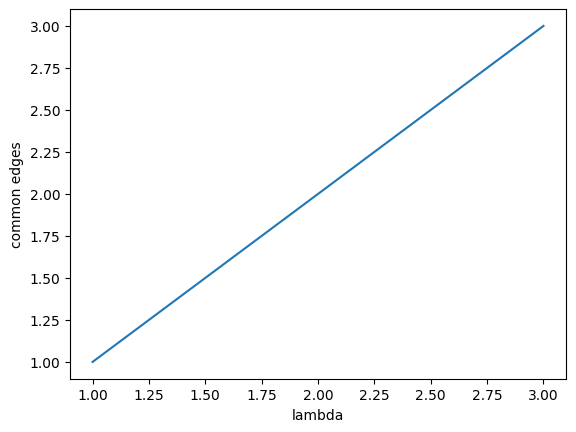

In [11]:
y = intersections_with_opt[1:]
plt.plot(lambds, y)
plt.ylabel('common edges')
plt.xlabel('lambda')

## Retrain

In [12]:
layers = 2
batch_size = 96
log_frequency = 20
channels = 16
unrolled = False
visualization = False
dataset = 'cifar100'

In [13]:
from retrain import train, validate, fixed_arch
# reload(train)

config = {
'layers' : layers,
'batch_size' : batch_size,
'log_frequency' : log_frequency,
'epochs' : 50,
'aux_weight' : 0.4,
'drop_path_prob' : 0.1,
'workers' : 4,
'grad_clip' : 5.,
'save_folder' : f"./checkpoints/{dataset}/",
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset_train, dataset_valid = datasets.get_dataset(dataset, cutout_length=16)

best_top1s = {}
for lambd in [1, 2, 3]:
    if lambd == 0:
        folder = config['save_folder'] + "optimal/"
    else:
        folder = config['save_folder'] + f"random_edges/lambd={lambd}/"
    print(folder)
    with fixed_arch(folder + 'arc.json'):
    # with fixed_arch(args.save_folder + "/arc.json"):
        if dataset == 'fashionMNIST':
            model = CNN(32, 1, 36, 10, config['layers'], auxiliary=True)
        if dataset == 'cifar100':
            model = CNN(32, 3, 36, 100, config['layers'], auxiliary=True)

    criterion = nn.CrossEntropyLoss()

    model.to(device)
    criterion.to(device)

    optimizer = torch.optim.SGD(model.parameters(), 0.025, momentum=0.9, weight_decay=3.0E-4)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, config['epochs'], eta_min=1E-6)

    train_loader = torch.utils.data.DataLoader(dataset_train,
                                            batch_size=config['batch_size'],
                                            shuffle=True,
                                            num_workers=config['workers'],
                                            pin_memory=True)
    valid_loader = torch.utils.data.DataLoader(dataset_valid,
                                            batch_size=config['batch_size'],
                                            shuffle=False,
                                            num_workers=config['workers'],
                                            pin_memory=True)

    best_top1 = 0.
    for epoch in range(config['epochs']):
        drop_prob = config['drop_path_prob'] * epoch / config['epochs']
        model.drop_path_prob(drop_prob)

        # training
        train(config, train_loader, model, optimizer, criterion, epoch)

        # validation
        cur_step = (epoch + 1) * len(train_loader)
        top1 = validate(config, valid_loader, model, criterion, epoch, cur_step)
        best_top1 = max(best_top1, top1)

        lr_scheduler.step()

    torch.save(model.state_dict(), folder + "mod.json")
    # torch.save(model.state_dict(), args.save_folder + "/mod.json")
    print("Final best Prec@1 = {:.4%}".format(best_top1))
    best_top1s.update({f'lambd={lambd}' : best_top1})
    print(best_top1s)

Files already downloaded and verified
Files already downloaded and verified
./checkpoints/cifar100/random_edges/lambd=1/
[2024-01-26 23:42:10] Fixed architecture: {'reduce_n2_p0': 'dilconv3x3', 'reduce_n2_p1': 'sepconv5x5', 'reduce_n3_p0': 'sepconv5x5', 'reduce_n3_p1': 'sepconv5x5', 'reduce_n3_p2': 'sepconv5x5', 'reduce_n4_p0': 'sepconv3x3', 'reduce_n4_p1': 'skipconnect', 'reduce_n4_p2': 'sepconv5x5', 'reduce_n4_p3': 'sepconv5x5', 'reduce_n5_p0': 'maxpool', 'reduce_n5_p1': 'avgpool', 'reduce_n5_p2': 'maxpool', 'reduce_n5_p3': 'sepconv5x5', 'reduce_n5_p4': 'maxpool', 'reduce_n2_switch': [0], 'reduce_n3_switch': [2], 'reduce_n4_switch': [0], 'reduce_n5_switch': [1]}
[2024-01-26 23:42:10] Epoch 0 LR 0.025000
[2024-01-26 23:42:19] Train: [  1/50] Step 000/520 Loss 6.508 Prec@(1,5) (0.0%, 2.1%)
[2024-01-26 23:42:19] Train: [  1/50] Step 020/520 Loss 6.387 Prec@(1,5) (2.1%, 7.3%)
[2024-01-26 23:42:20] Train: [  1/50] Step 040/520 Loss 6.262 Prec@(1,5) (2.6%, 11.1%)
[2024-01-26 23:42:20] Trai

In [1]:
for ww in ['yes', 'no']:
    for wt in ['no']:
        for l in [1, 2, 3]:
            print(ww, wt, l, best_top1s[f'lambd={l}, ww={ww}, wt={wt}'])

NameError: name 'best_top1s' is not defined

## Validation

In [39]:
from retrain import train, validate, fixed_arch
import numpy as np
from glob import glob
from nni.retiarii.oneshot.pytorch.utils import AverageMeter
from torch.utils.tensorboard import SummaryWriter

logger = logging.getLogger('nni')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter()
n_chosen = 1

config = {
'layers' : 2,
'batch_size' : 96,
'log_frequency' : 30,
'epochs' : 10,
'aux_weight' : 0.4,
'drop_path_prob' : 0.1,
'workers' : 4,
'grad_clip' : 5.,
'save_folder' : "./checkpoints/cifar100/",
}

dataset_train, dataset_valid = datasets.get_dataset("cifar100", cutout_length=16)

res_dict_accur = {}
models = []

# chosen_lambdas = np.random.choice(8, size=3, replace=False) # выбранные lambda
chosen_lambdas = [3]

print(chosen_lambdas)

for dir in glob(config['save_folder'] + "*"):
    if dir.split('\\')[-1] != 'optimal' and dir.split('\\')[-1] != 'random' and int(dir.split('\\')[-1].split('=')[-1]) in chosen_lambdas:
    # if dir == "./checkpoints\\0":
        print(dir)
        folder = dir + "/ww=nowt=no/"
        with fixed_arch(folder + "arc1.json"):
            model = CNN(32, 3, 36, 100, config['layers'], auxiliary=True, n_chosen=n_chosen)
        model.to(device)
        model.load_state_dict(torch.load(folder + "mod1.json"))
        model.eval()
            
        models.append(model)

    elif dir.split('\\')[-1] == 'optimal' and 0 in chosen_lambdas:
        print(dir)
        folder = dir + "/"
        with fixed_arch(folder + "arc1.json"):
            model = CNN(32, 3, 36, 100, config['layers'], auxiliary=True, n_chosen=n_chosen)
        model.to(device)
        model.load_state_dict(torch.load(folder + "mod1.json"))
        model.eval()
            
        models.append(model)
         

print(f"Models in ensemble: {len(models)}")

valid_loader = torch.utils.data.DataLoader(dataset_valid,
                                            batch_size=config['batch_size'],
                                            shuffle=False,
                                            num_workers=config['workers'],
                                            pin_memory=True)
criterion = nn.CrossEntropyLoss()

top1 = AverageMeter("top1")
top5 = AverageMeter("top5")
losses = AverageMeter("losses")

# validation
softmax = nn.Softmax(dim=1)
for step, (X, y) in enumerate(valid_loader):
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
        bs = X.size(0)

        probabilities = softmax(models[0](X))
        for i in range(1, len(models)):
            probabilities += softmax(models[i](X))
        probabilities = probabilities / len(models)
        loss = criterion(probabilities, y)

        accuracy = utils.accuracy(probabilities, y, topk=(1, 5))
        losses.update(loss.item(), bs)
        top1.update(accuracy["acc1"], bs)
        top5.update(accuracy["acc5"], bs)

        if step % config['log_frequency'] == 0 or step == len(valid_loader) - 1:
            logger.info(
                "Valid: Step {:03d}/{:03d} Loss {losses.avg:.3f} "
                "Prec@(1,5) ({top1.avg:.1%}, {top5.avg:.1%})".format(
                    step, len(valid_loader) - 1, losses=losses,
                    top1=top1, top5=top5))

logger.info("Final best Prec@1 = {:.4%}".format(top1.avg))

# res_dict_accur[chosen_lambdas] = top1.avg
print(top1.avg)

Files already downloaded and verified
Files already downloaded and verified
[3]
./checkpoints/cifar100\lambd=3
[2024-01-16 15:26:20] Fixed architecture: {'reduce_n2_p0': 'avgpool', 'reduce_n2_p1': 'sepconv5x5', 'reduce_n3_p0': 'sepconv5x5', 'reduce_n3_p1': 'sepconv3x3', 'reduce_n3_p2': 'sepconv5x5', 'reduce_n4_p0': 'sepconv3x3', 'reduce_n4_p1': 'sepconv5x5', 'reduce_n4_p2': 'dilconv5x5', 'reduce_n4_p3': 'sepconv5x5', 'reduce_n5_p0': 'skipconnect', 'reduce_n5_p1': 'dilconv3x3', 'reduce_n5_p2': 'sepconv5x5', 'reduce_n5_p3': 'dilconv5x5', 'reduce_n5_p4': 'maxpool', 'reduce_n2_switch': [1], 'reduce_n3_switch': [2], 'reduce_n4_switch': [0], 'reduce_n5_switch': [4]}
Models in ensemble: 1
[2024-01-16 15:26:24] Valid: Step 000/104 Loss 3.992 Prec@(1,5) (64.6%, 86.5%)
[2024-01-16 15:26:24] Valid: Step 030/104 Loss 4.039 Prec@(1,5) (61.6%, 87.8%)
[2024-01-16 15:26:24] Valid: Step 060/104 Loss 4.038 Prec@(1,5) (61.7%, 88.3%)
[2024-01-16 15:26:24] Valid: Step 090/104 Loss 4.037 Prec@(1,5) (62.1%, 